### Batches

In [1]:
import cv2
import numpy as np
import pandas as pd
from sklearn.utils import shuffle
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import os
import pickle
import copy
from PIL import Image
from skimage import exposure

In [2]:
def saveToPickle(data, file_name=None, folder_path=None):
    if not os.path.isdir(folder_path):
        #print("Create \"preprocessed-data\" folder")
        os.mkdir(folder_path)
    else:
        print("\"preprocessed-data\" folder already exist")

    file_name = folder_path + file_name
    if not os.path.exists(file_name):
        try:
            with open(file_name, 'wb') as f:
                pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
                print("Create", file_name)
        except Exception as e:
            print('Error: unable to save data to', file_name, 'because', e)
            
def loadPickle(file_name=None, folder_path=None):
    file = folder_path + file_name
    #print('Load')
    if os.path.exists(file):
        try:
            with open(file, 'rb') as f:
                return pickle.load(f)
                print("Open", file)
        except Exception as e:
            print('Error: unable to open data to', file, 'because', e)

In [3]:
## Load
augmented_X_train = loadPickle(file_name='augmented_X_train.p', folder_path='./preprocessed-data/')
augmented_y_train = loadPickle(file_name='augmented_y_train.p', folder_path='./preprocessed-data/')

augmented_X_valid = loadPickle(file_name='augmented_X_valid.p', folder_path='./preprocessed-data/')
augmented_y_valid = loadPickle(file_name='augmented_y_valid.p', folder_path='./preprocessed-data/')

augmented_X_test = loadPickle(file_name='augmented_X_test.p', folder_path='./preprocessed-data/')
augmented_y_test = loadPickle(file_name='augmented_y_test.p', folder_path='./preprocessed-data/')

print('The shape of the loaded processed X train dataset:', augmented_X_train.shape)
print('The shape of the loaded processed y train dataset:', augmented_y_train.shape)

print('The shape of the loaded processed X valid dataset:', augmented_X_valid.shape)
print('The shape of the loaded processed y valid dataset:', augmented_y_valid.shape)

print('The shape of the loaded processed X test dataset:', augmented_X_test.shape)
print('The shape of the loaded processed y test dataset:', augmented_y_test.shape)

The shape of the loaded processed X train dataset: (86430, 32, 32)
The shape of the loaded processed y train dataset: (86430,)
The shape of the loaded processed X valid dataset: (10320, 32, 32)
The shape of the loaded processed y valid dataset: (10320,)
The shape of the loaded processed X test dataset: (32250, 32, 32)
The shape of the loaded processed y test dataset: (32250,)


In [4]:
import math
def batches(batch_size, features, labels):
    """
    Create batches of features and labels
    :param batch_size: The batch size
    :param features: List of features
    :param labels: List of labels
    :return: Batches of (Features, Labels)
    """
    if batch_size > 0:
        assert len(features) == len(labels)

        output_batches = []
        sample_size = len(features)

        for start_i in range(0, sample_size, batch_size):
            end_i = start_i + batch_size
            batch = [features[start_i:end_i], labels[start_i:end_i]]
            output_batches.append(batch)
    else:
        assert len(features) == len(labels)
        
        output_batches = []
        sample_size = len(features)
        
        for start in range(sample_size):
            batch = [features[start], labels[start]]
            output_batches.append(batch)
            
    return output_batches

### Model Architecture

In [5]:
rate = 0.001
EPOCHS = 30
BATCH_SIZE = 32

In [6]:
from tensorflow.contrib.layers import flatten

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    ## Layer 1: ##
    # Convolutional. Input = 32x32x3. Output = 28x28x32.
    conv_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 128), mean = mu, stddev = sigma))
    conv_b = tf.Variable(tf.zeros(128))
    conv   = tf.nn.conv2d(x, conv_W, strides=[1, 1, 1, 1], padding='VALID') + conv_b
    
    # Activation.
    conv = tf.nn.relu(conv)
    conv = tf.nn.dropout(conv, 0.7)
    
    #conv = tf.nn.max_pool(conv, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    ## Layer 2 ##
    # Convolutional. Input = 32x32x3. Output = 28x28x32.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 128, 256), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(256))
    conv1   = tf.nn.conv2d(conv, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)
    conv1 = tf.nn.dropout(conv1, 0.7)

    # Pooling. Input = 28x28x32. Output = 14x14x32.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    ## Layer 3: ##
    # Convolutional. Output = 10x10x64.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 256, 384), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(384))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)
    conv2 = tf.nn.dropout(conv2, 0.7)

    # Pooling. Input = 10x10x64. Output = 5x5x64.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x64. Output = 1600.
    fc0   = flatten(conv2)
    
    ## Layer 4: ## 
    # Fully Connected. Input = 1600. Output = 1200.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(6144, 3072), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(3072))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1, 0.6)

    ## Layer 5: ##
    # Fully Connected. Input = 1200. Output = 840.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(3072, 1536), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(1536))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2, 0.5)

    # Layer 6: Fully Connected. Input = 840. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(1536, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

### Train, Validate and Test the Model

In [7]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

## Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [8]:
## Training Pipeline
logits =  LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [9]:
## Model Evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, batch_size, sess):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()

    for batch_x, batch_y in tqdm(batches(batch_size, X_data, y_data)):
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [10]:
## Reshape dataset
augmented_X_train = np.reshape(augmented_X_train, (len(augmented_X_train), 32, 32, 1))
augmented_X_valid = np.reshape(augmented_X_valid, (len(augmented_X_valid), 32, 32, 1))
augmented_X_test = np.reshape(augmented_X_test, (len(augmented_X_test), 32, 32, 1))
print(augmented_X_train[:128].shape)

(128, 32, 32, 1)


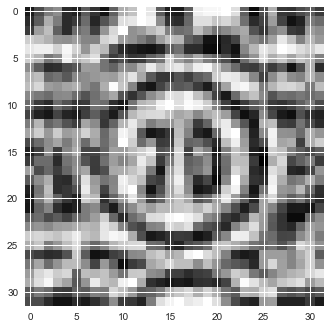

In [14]:
plt.imshow(augmented_X_train[7806, :, :, 0], cmap='gray')

In [11]:
## Train the Model

with tf.Session() as session:
    session.run(tf. global_variables_initializer())
    num_examples = len(augmented_X_train)
    
    print("Training...")
    #print()
    for i in range(EPOCHS):
        shuffle_X, shuffle_y = shuffle(augmented_X_train, augmented_y_train)
        for batch_x, batch_y in tqdm(batches(BATCH_SIZE, shuffle_X, shuffle_y)):
            session.run(training_operation, feed_dict={x: batch_x, y: batch_y})
        
        validation_accuracy = evaluate(augmented_X_valid, augmented_y_valid, BATCH_SIZE, session)
        print("EPOCH {0} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    saver.save(session, './CNN3')
    print("Model Saved")

Training...


100%|████████████████████████████████████████| 323/323 [00:13<00:00, 24.41it/s]


EPOCH 1 ...
Validation Accuracy = 0.022



 27%|██████████▋                            | 740/2701 [01:31<04:00,  8.15it/s]

KeyboardInterrupt: 